In [24]:
# Vinh Nghiem
# Project 5

import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
%matplotlib inline



# Load Dataset

In [2]:
def get_dataset(root_dir):
    images = []
    for path, folders, files in os.walk(root_dir):
        for file in files:
            if '.DS_Store' not in file:
                #print (os.path.join(path, file))
                images.append(os.path.join(path, file))
    return list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), images))



In [3]:
cars = get_dataset("dataset/vehicles")
print(len(cars))



8792


In [4]:
not_cars = get_dataset("dataset/non-vehicles")
print(len(not_cars))

8968


# Show Sample Images


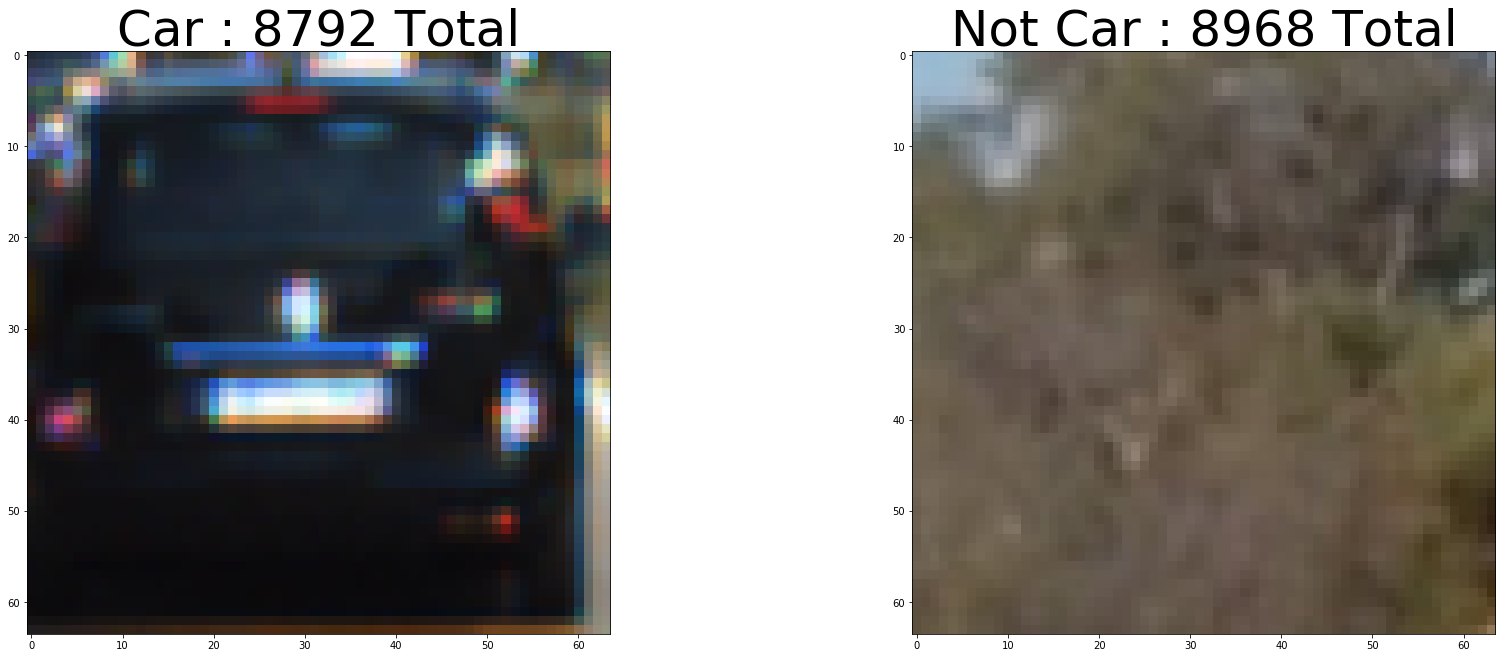

In [5]:
def show_images(image1, title1, image2, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(image2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

random_car = random.choice(cars)
random_notcar = random.choice(not_cars)
show_images(random_car, "Car : " + str(len(cars))+" Total", random_notcar, "Not Car : " + str(len(not_cars)) + " Total" )


# Extract Features

In [6]:
def convert_color(img, color_space='RGB'):
    feature_image = None
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            #print ("hanging out in YCrCb land")
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        #print ("in no man's land")
        feature_image = np.copy(img)      
    
    return feature_image

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
                       

    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L1',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L1',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)

        

    return features


class Parameters():
    def __init__ (self, color_space='RGB', spatial_size=(32, 32), 
                  hist_bins=8, orient=9, pix_per_cell=8, 
                  cell_per_block=2, hog_channel=0, scale = 1.5,
                  hist_range = (0, 256), spatial_feat=True, 
                  hist_feat=True, hog_feat=True):
        # color spatial feature
        self.spatial_size = spatial_size
        # color histogram features
        self.color_space = color_space
        self.hist_bins = hist_bins
        self.hist_range = hist_range
        # HOG features
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.scale = scale
        # features on or off
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat

def get_image_features(img, params):    
    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, params.color_space)
    #3) Compute spatial features if flag is set
    if params.spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=params.spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if params.hist_feat == True:
        hist_features = color_hist(feature_image, nbins=params.hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if params.hog_feat == True:
        if params.hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,params.hog_channel], params.orient, 
                        params.pix_per_cell, params.cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

params = Parameters(color_space = 'YCrCb', 
                    spatial_feat=True, 
                    spatial_size = (16, 16),
                    hist_feat=True, 
                    hist_bins = 32,
                    hog_feat=True, 
                    scale = 1.5,
                    orient = 8, 
                    pix_per_cell = 8, 
                    cell_per_block = 2, 
                    hog_channel = 'ALL')

print("Loading features ...")
sample_size = 8750

cars = cars[0:sample_size]
not_cars = not_cars[0:sample_size]

car_features = list(map(lambda img: get_image_features(img, params), cars))
not_car_features = list(map(lambda img: get_image_features(img, params), not_cars))

print ("Done")





Loading features ...


/Applications/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Done


In [7]:
# Display HOG Features

/Applications/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


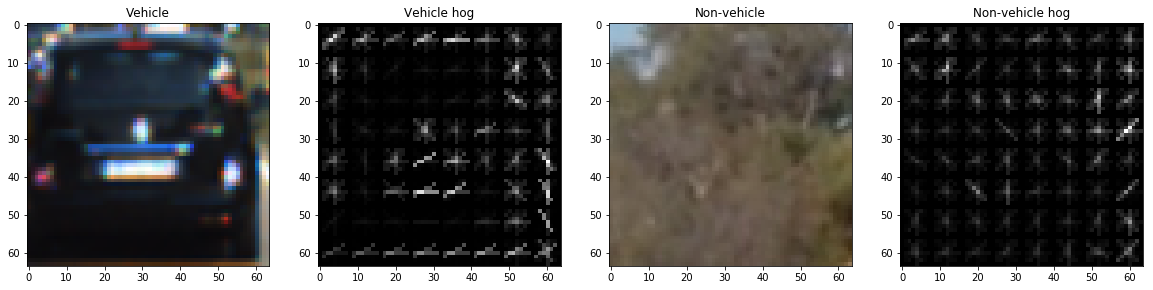

In [8]:
def show_hog(vehicle, non_vehicle, params):
    _,vehicle_hog = get_hog_features(vehicle[:,:,0],params.orient, params.pix_per_cell, params.cell_per_block, vis=True, feature_vec=True)
    _,non_vehicle_hog = get_hog_features(non_vehicle[:,:,0],params.orient, params.pix_per_cell, params.cell_per_block, vis=True, feature_vec=True)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
    ax1.set_title('Vehicle')
    ax1.imshow(vehicle, cmap='gray')
    ax2.set_title('Vehicle hog')
    ax2.imshow(vehicle_hog, cmap='gray')
    ax3.set_title('Non-vehicle')
    ax3.imshow(non_vehicle, cmap='gray')
    ax4.set_title('Non-vehicle hog')
    ax4.imshow(non_vehicle_hog, cmap='gray')
    
show_hog(random_car, random_notcar, params)

In [9]:
# Train classifier

In [10]:
###### print ("Training classifier ...")
X = np.vstack((car_features, not_car_features)).astype(np.float64)                        
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))
rand_state = np.random.randint(0, 100)

# Split up data into randomized training and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
X_scaler = StandardScaler().fit(X_train)
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

print('Using:',params.orient,'orientations',params.pix_per_cell,
    'pixels per cell and', params.cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(scaled_X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(scaled_X_test, y_test), 4))



Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568
21.01 Seconds to train SVC...
Test Accuracy of SVC =  0.9923


# Find Cars in Image with HOG Subsampling



/Applications/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


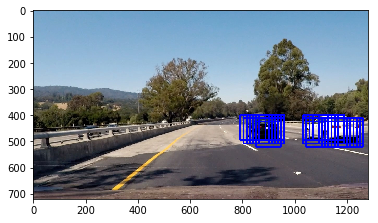

In [11]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def find_cars(img, ystart, ystop, svc, X_scaler, params, cells_per_step = 1):
    
    draw_img = np.copy(img)
    
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space=params.color_space)
    
    if params.scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/params.scale), np.int(imshape[0]/params.scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // params.pix_per_cell) - params.cell_per_block + 1
    nyblocks = (ch1.shape[0] // params.pix_per_cell) - params.cell_per_block + 1 
    nfeat_per_block = params.orient*params.cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // params.pix_per_cell) - params.cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)
    car_windows=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*params.pix_per_cell
            ytop = ypos*params.pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=params.spatial_size)
            hist_features = color_hist(subimg, nbins=params.hist_bins, bins_range=params.hist_range)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*params.scale)
                ytop_draw = np.int(ytop*params.scale)
                win_draw = np.int(window*params.scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, car_windows



ystart = 400
ystop = 656
img = cv2.cvtColor(cv2.imread('test_images/test4.jpg'), cv2.COLOR_BGR2RGB)

out_img, windows = find_cars(img, ystart, ystop, svc, X_scaler, params)

plt.imshow(out_img)
plt.show()




# Handling Multiple Detections and False Positives


In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

from scipy.ndimage.measurements import label

def heat_threshold(img, threshold, svc, X_scaler, windows_list, params):

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,windows_list)
    


    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    
    ######heatmap = combine_prev(heat)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    #draw_img = draw_boxes(np.copy(img), windows_list)
    return draw_img, heatmap

def combine_prev(heatmap):
    return heatmap*prev_heatmap

/Applications/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


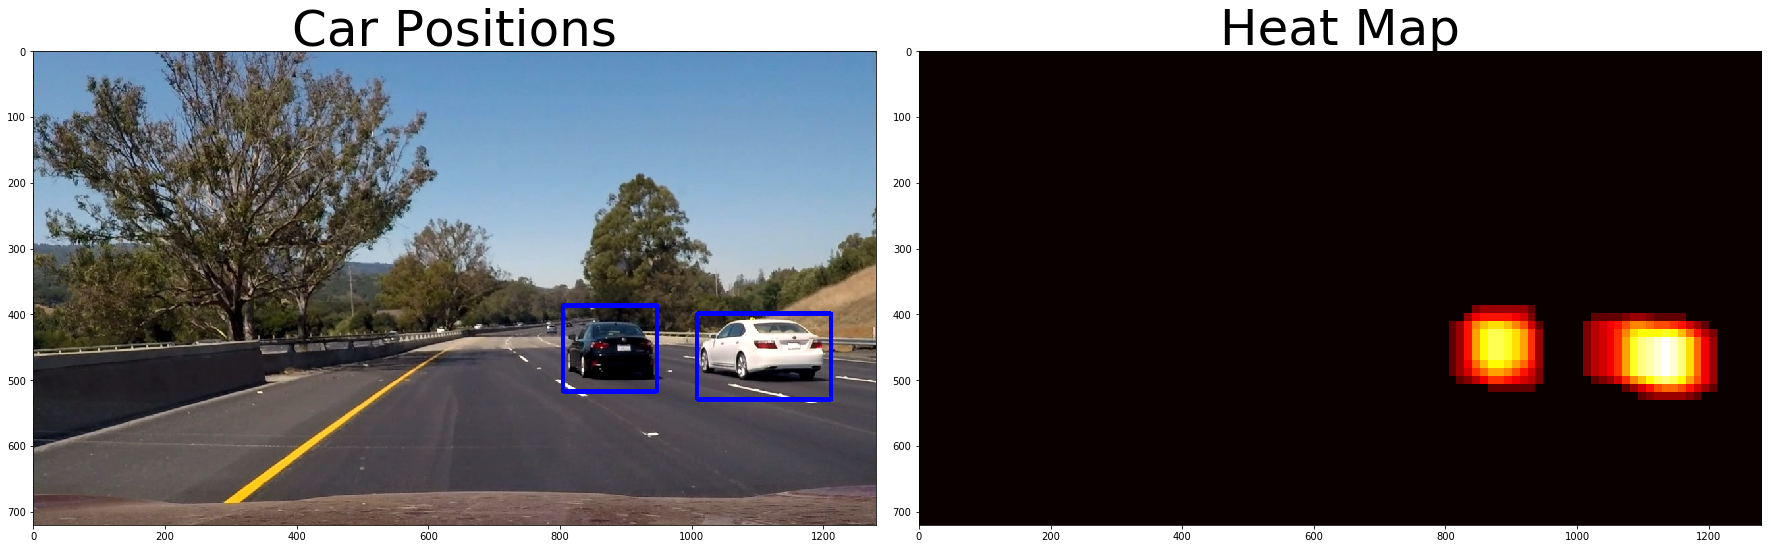

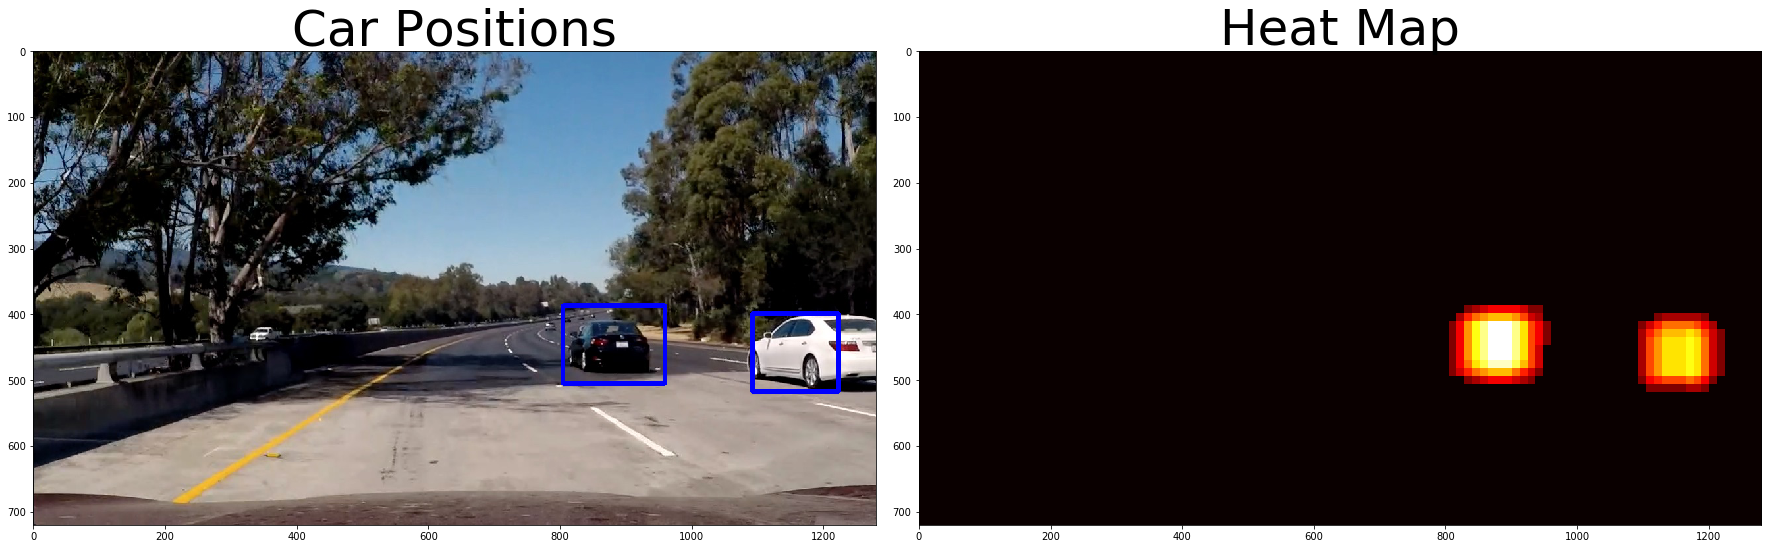

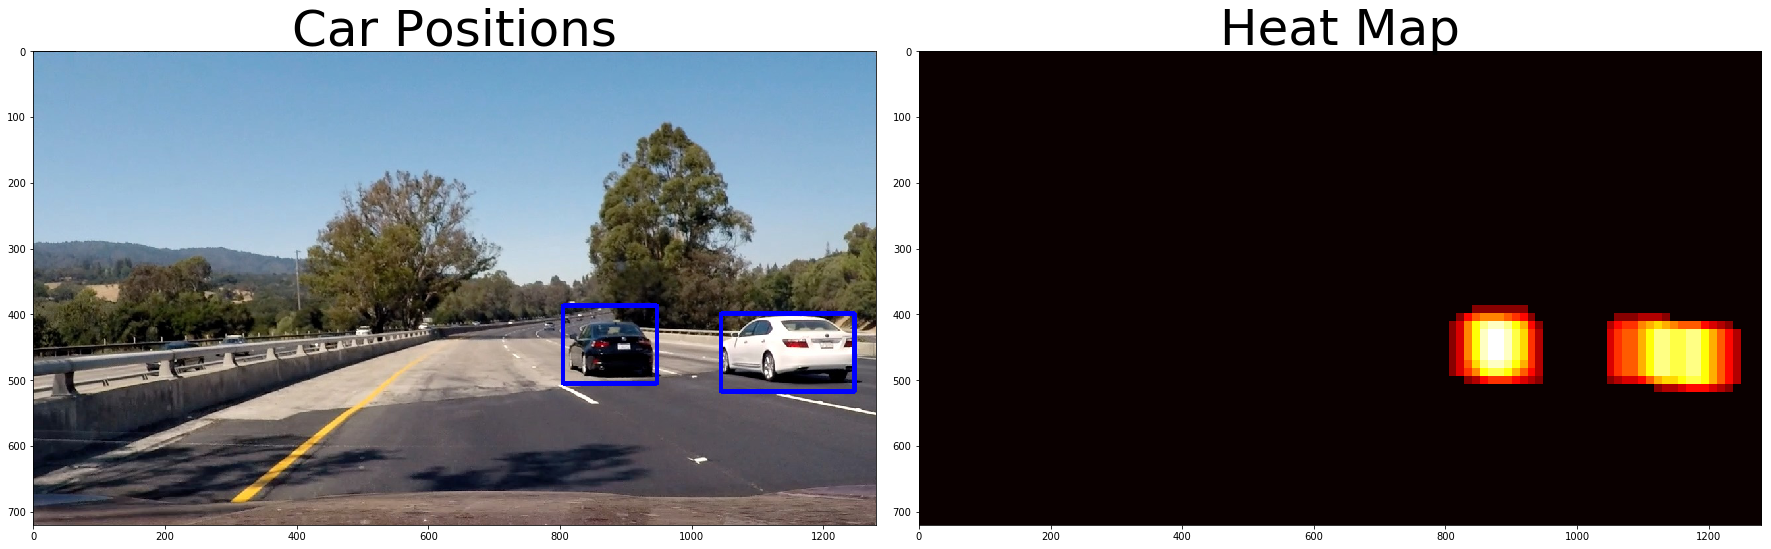

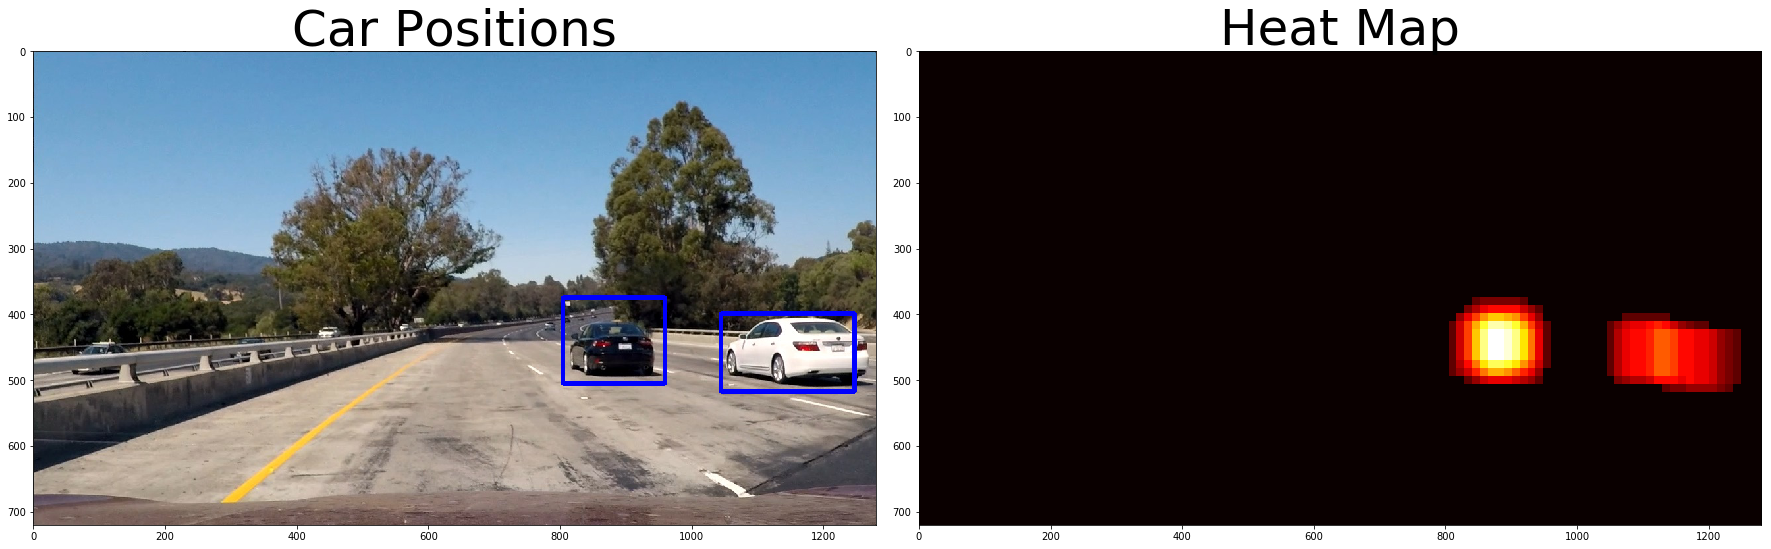

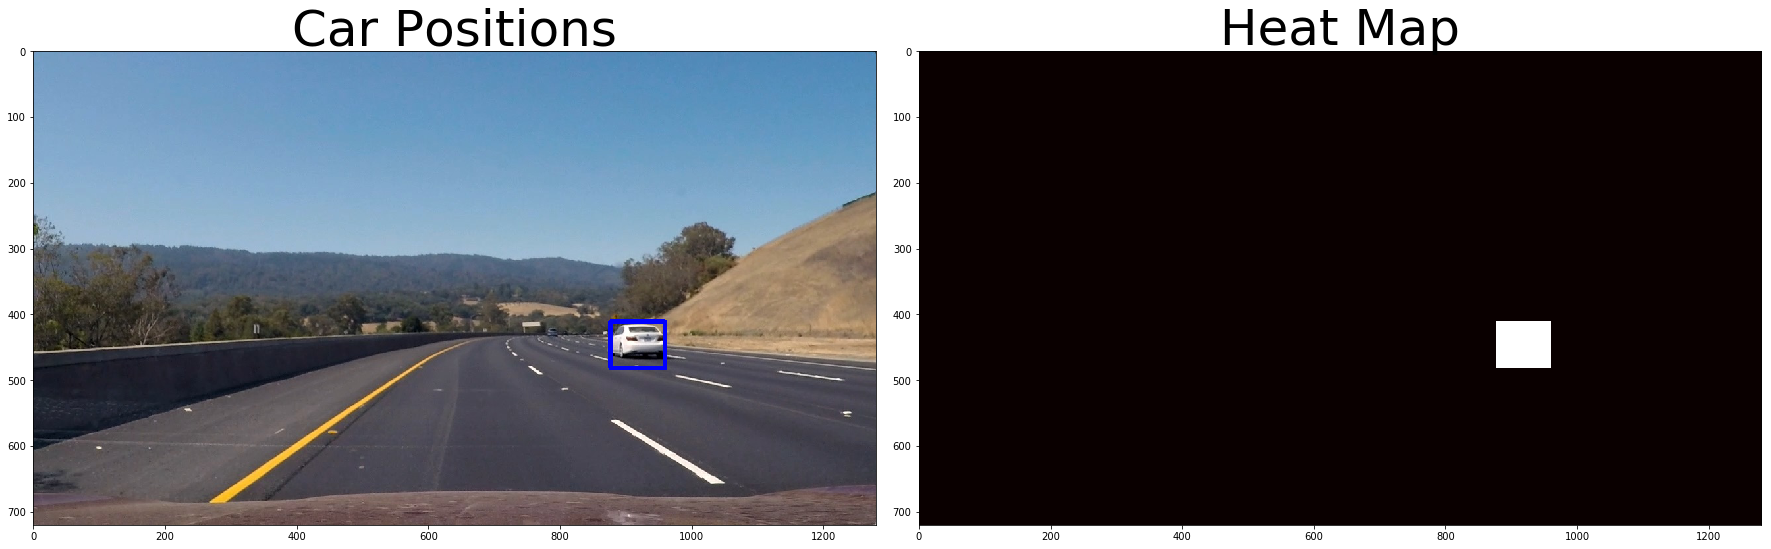

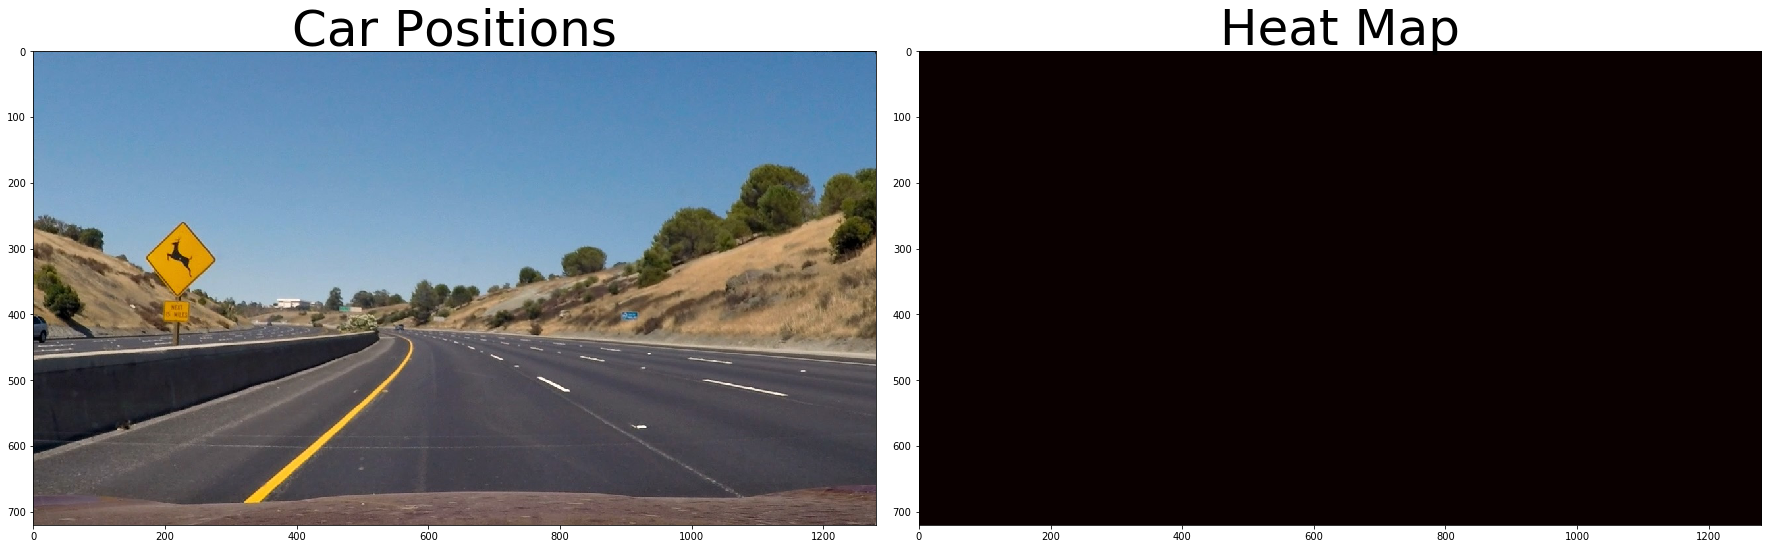

In [13]:


def show_heatmap_images(image1, title1, image2, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(image2, cmap='hot')
    #ax2.imshow(image2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# import os
# from advanced_lane_detection import *

ystart = 350
ystop = 656

threshold = 3

test_images = []
root = "test_images"

# calibration_directory = 'camera_cal'
# test_directory = 'test_images'
# output_directory = 'output_images'
# #warp_image_file = "test_images/test2.jpg"
# nx = 9 # the number of inside corners in x
# ny = 6 # the number of inside corners in y

# source_points = []
# dest_points = []
# calibration_success, (retVal, mtx, dist, rvecs, tvecs) = calibrate_camera(calibration_directory, nx, ny) 
# prev_road = Road()

# print ('Calibration success = ', calibration_success) 


for file in os.listdir(root):
    if '.DS_Store' not in file:
        path_name = os.path.join(root,file)
        #test_images.append(path_name)
        
        img = cv2.cvtColor(cv2.imread(path_name), cv2.COLOR_BGR2RGB)    
        
#         undistorted, color_binary, combined_binary, warped_binary_with_lanes, unwarped_with_lanes, rad_curv_left, rad_curv_right = detect_lanes_in_image(img)
#         rad_curv = (rad_curv_left+rad_curv_right)/2.0
#         img = unwarped_with_lanes
        
        prev_heatmap = np.ones_like(img[:,:,0]).astype(np.float)
        windows_img,car_windows = find_cars(img, ystart, ystop, svc, X_scaler, params)
        draw_img, heatmap = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
        #heatmap = combine_prev(heatmap)
        show_heatmap_images(draw_img, 'Car Positions', heatmap, 'Heat Map')
        cv2.imwrite('output_images/' + file, cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR))
#print (np.ones([3,2]))
        


    

In [14]:
def pipeline(img):
    ystart = 350
    ystop = 656
    
    threshold = 3
 
    window_img, car_windows = find_cars(img, ystart, ystop, svc, X_scaler, params)
    draw_img, heatmap = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
    #heatmap = combine_prev(heatmap)
    prev_heatmap = heatmap
    return draw_img

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

img_size = (720, 1280)
prev_heatmap = np.ones(img_size).astype(np.float)

def process_pipeline(img):
    return pipeline(img)



project_clip = VideoFileClip("input_video/project_video.mp4")
project_frame = project_clip.fl_image(process_pipeline)
project_output = 'output_videos/project_video.mp4'
%time project_frame.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [48:28<00:02,  2.11s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 44min 44s, sys: 56.1 s, total: 45min 40s
Wall time: 48min 30s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

# Challenge

In [17]:
# mtx= None
# dist = None


def calibrate_camera(directory, nx, ny):

    file_names = os.listdir(directory + "/")

    objpoints = []
    imgpoints = []

    #Prepare object points
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    print ("Calibrating camera ...")
    for i, file_name in enumerate(file_names):
        img = mpimg.imread(directory + "/" + file_name)
        print ("Progress: ", float(i)/len(file_names)*100, "%")

        #Find chessboard corners
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        if ret==True:
            imgpoints.append(corners)
            objpoints.append(objp)
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #plt.imshow(img)
    if len(imgpoints)>0:        
        return True, cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    else:
        return False, (None,None,None,None,None)

def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def get_sobel_binary(img,type='x', thresh=(20,100)):
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if type=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    if type == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
    if type == 'mag':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        
    abs_sobel = np.absolute(sobel) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Threshold x gradient
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sobel_binary

def get_s_binary(img, thresh = (170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]  
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return s_binary

def combine_binary(sobel_binary, s_binary):
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1
    combined_binary = np.dstack(( combined_binary, combined_binary, combined_binary)) * 255

    return combined_binary
  
def mark_lanes(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Display lanes on warped image
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, left_fitx, right_fitx, ploty

def unwarp_with_lanes(warped, undistorted_img, left_fitx, right_fitx, ploty, dest, src):
    # warped binary image called warped, and the lines fitted with a 
    # polynomial and have arrays called ploty, left_fitx and right_fitx, 
    # which represent the x and y pixel values of the lines. 

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = cv2.getPerspectiveTransform(dest, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1.0, newwarp, 0.3, 0)
    
    #plt.imshow(result)
    return result

class Road:
    def __init__(self):
        self.first = True
        self.left_x = None
        self.right_x = None
        self.lane_offset = 0.0
        
    def update(self, left_x, right_x, offset):
        self.left_x = left_x
        self.right_x = right_x
        self.lane_offset = offset
        self.first = False
        
def sanity_test_passed(left_x, right_x, offset):
    #lanes parallel
    parallel_tolerance = 100
    
    lanes_parallel = abs ( abs(left_x[0]-right_x[0]) - abs(left_x[-1]-right_x[-1]) ) < parallel_tolerance 
    
    # in center
    center_tolerance = 0.2
    kept_center = abs(offset - prev_road.lane_offset) < center_tolerance
    
    return lanes_parallel and kept_center

def detect_lanes_in_image(img):
    undistorted = undistort(img, mtx, dist)
 
    sobel_binary = get_sobel_binary(undistorted, thresh = (20,100))
    s_binary = get_s_binary(undistorted, thresh = (170, 255))

    combined_binary = combine_binary(sobel_binary, s_binary)

    color_binary = np.dstack((sobel_binary, np.zeros_like(sobel_binary), s_binary)) * 255


    src = np.float32([[568,468],[717,468],[1077,717],[217, 717]])
 
    offset = 300
    img_size = (undistorted.shape[1], undistorted.shape[0])
    
    dest = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                                     [img_size[0]-offset, img_size[1]], 
                                     [offset, img_size[1]]])

    M = cv2.getPerspectiveTransform(src, dest)
    
    warped = cv2.warpPerspective(undistorted, M, img_size)

    warped_binary = cv2.warpPerspective(combined_binary, M, img_size)

    warped_binary_with_lanes, left_fitx, right_fitx, ploty = mark_lanes(warped_binary[:,:,0])
    
    rad_curv_left, rad_curv_right, off_center = get_rad_curv(left_fitx, right_fitx, ploty, img_size)
    rad_curv = (rad_curv_left+rad_curv_right)/2.0
    
    if prev_road.first==True or sanity_test_passed(left_fitx, right_fitx, off_center) == True:     
 #       print ("sanity test passed!")
        unwarped_with_lanes = unwarp_with_lanes(warped_binary[:,:,0], undistorted, left_fitx, right_fitx, ploty, dest, src) 
        prev_road.update(left_fitx, right_fitx, off_center)
    
    else:
 #       print ("sanity test failed! I am insane!")
        unwarped_with_lanes = unwarp_with_lanes(warped_binary[:,:,0], undistorted, prev_road.left_x, prev_road.right_x, ploty, dest, src) 
        rad_curv_left, rad_curv_right, off_center = get_rad_curv(prev_road.left_x, prev_road.right_x, ploty, img_size)
        rad_curv = (rad_curv_left+rad_curv_right)/2.0
        
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(unwarped_with_lanes,'Radius of Curvature: '+str(rad_curv_left)+"m",(100,100), font, 1,(255,255,255),2,cv2.LINE_AA)

    if (off_center<0):
        cv2.putText(unwarped_with_lanes,'Vehicle is '+str(abs(off_center))+"m left of center",(100,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    else:
        cv2.putText(unwarped_with_lanes,'Vehicle is '+str(abs(off_center))+"m right of center",(100,150), font, 1,(255,255,255),2,cv2.LINE_AA)


        
    return undistorted, color_binary, combined_binary, warped_binary_with_lanes, unwarped_with_lanes, rad_curv_left, rad_curv_right
  
def process_img(img):
    undistorted, color_binary, combined_binary, warped_binary_with_lanes, unwarped_with_lanes, rad_curv_left, rad_curv_right = detect_lanes_in_image(img)
    return unwarped_with_lanes

def get_rad_curv(leftx, rightx, ploty, img_size):
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    
    ym_per_pix = 3.048/220 # meters per pixel in y dimension (vertical length of a dashed line is 3.048m)
    xm_per_pix = 3.7/680 # meters per pixel in x dimension (horizontal width of a lane is 3.7m)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Calculate where vehicle is off-center
    off_center  = ((rightx[-1] + leftx[-1])/2.0 - img_size[0]/2.0) * xm_per_pix
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad, off_center

Calibrating camera ...
Progress:  0.0 %
Progress:  5.0 %
Progress:  10.0 %
Progress:  15.0 %
Progress:  20.0 %
Progress:  25.0 %
Progress:  30.0 %
Progress:  35.0 %
Progress:  40.0 %
Progress:  45.0 %
Progress:  50.0 %
Progress:  55.00000000000001 %
Progress:  60.0 %
Progress:  65.0 %
Progress:  70.0 %
Progress:  75.0 %
Progress:  80.0 %
Progress:  85.0 %
Progress:  90.0 %
Progress:  95.0 %
Calibration success =  True


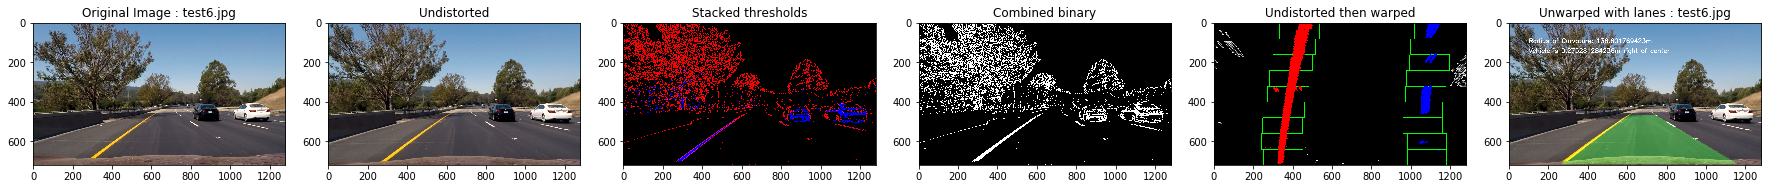

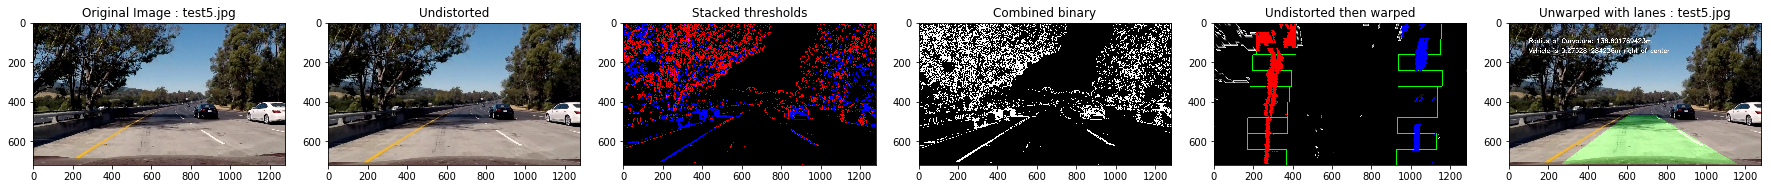

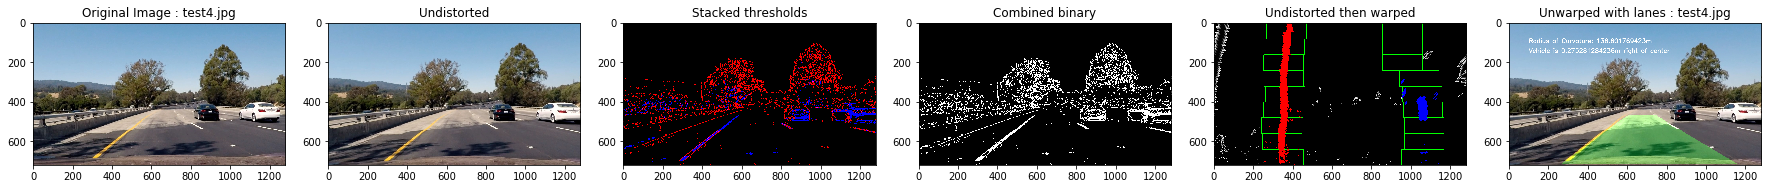

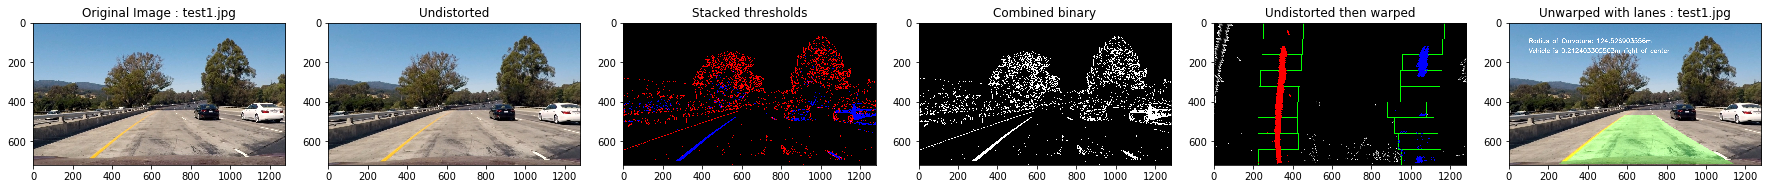

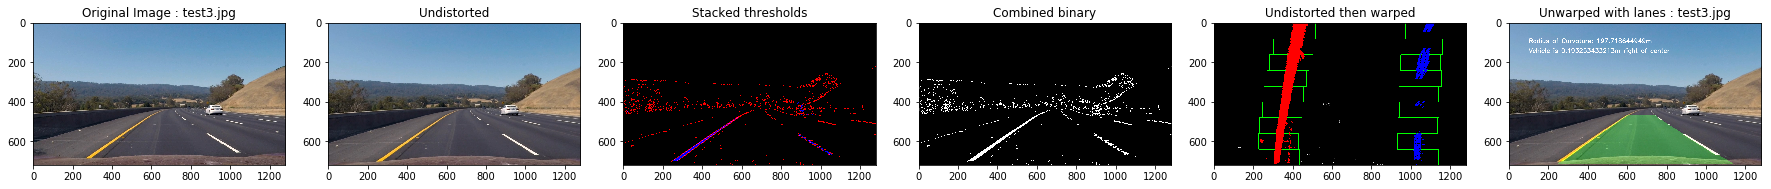

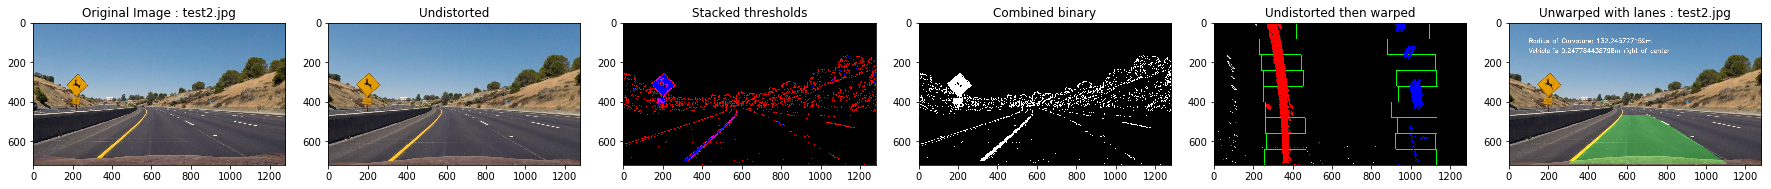

In [18]:
from pylab import savefig
import os

calibration_directory = 'camera_cal'
test_directory = 'test_images'
output_directory = 'output_images'
#warp_image_file = "test_images/test2.jpg"
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

mtx= None
dist = None
source_points = []
dest_points = []
calibration_success, (retVal, mtx, dist, rvecs, tvecs) = calibrate_camera(calibration_directory, nx, ny) 
prev_road = Road()

print ('Calibration success = ', calibration_success) 
if calibration_success==True: 
    for file_name in os.listdir(test_directory): 
        if '.DS_Store' not in file_name:
            img = mpimg.imread(test_directory + '/' + file_name)
            undistorted, color_binary, combined_binary, warped_binary_with_lanes, unwarped_with_lanes, rad_curv_left, rad_curv_right = detect_lanes_in_image(img)
            rad_curv = (rad_curv_left+rad_curv_right)/2.0

            # ################ Plotting starts here


            fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(24, 9))
            fig.tight_layout()

            ax1.imshow(img)
            ax1.set_title('Original Image : ' + file_name)

            ax2.imshow(undistorted)
            ax2.set_title('Undistorted')

            ax3.set_title('Stacked thresholds')
            ax3.imshow(color_binary)

            ax4.set_title('Combined binary')
            ax4.imshow(combined_binary)

            ax5.set_title('Undistorted then warped')
            #ax4.imshow(warped)
            ax5.imshow(warped_binary_with_lanes)

            ax6.set_title('Unwarped with lanes : ' + file_name)
            ax6.imshow(unwarped_with_lanes)

            cv2.imwrite('output_images/' + file_name, cv2.cvtColor(unwarped_with_lanes, cv2.COLOR_RGB2BGR))

            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [19]:
def detect_vehicles(img):
    ystart = 350
    ystop = 656
    
    threshold = 3
 
    window_img, car_windows = find_cars(img, ystart, ystop, svc, X_scaler, params)
    draw_img, heatmap = heat_threshold(img, threshold, svc, X_scaler, car_windows, params)
    #heatmap = combine_prev(heatmap)
    #prev_heatmap = heatmap
    return draw_img

def detect_lanes(img):
    undistorted, color_binary, combined_binary, warped_binary_with_lanes, unwarped_with_lanes, rad_curv_left, rad_curv_right = detect_lanes_in_image(img)
    return unwarped_with_lanes

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

img_size = (720, 1280)
#prev_heatmap = np.ones(img_size).astype(np.float)

prev_road.first = True

def process_challenge(img):
#     vehicles_detected_img = detect_vehicles(img) 
#     final_img = detect_lanes(vehicles_detected_img)
    lanes_detected_img = detect_lanes(img) 
    final_img = detect_vehicles(lanes_detected_img)
    return final_img


challenge_clip = VideoFileClip("input_video/project_video.mp4")
challenge_frame = challenge_clip.fl_image(process_challenge) #NOTE: this function expects color images!!
challenge_output = 'output_videos/challenge_video.mp4'
%time challenge_frame.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|█████████▉| 1260/1261 [49:57<00:02,  2.17s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

CPU times: user 48min 48s, sys: 1min 28s, total: 50min 17s
Wall time: 49min 59s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))